### Importing Necessary Libraries and Making Initial Configurations

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from glob import glob

import librosa
import librosa.display
import IPython.display as ipd

from itertools import cycle
import math

sns.set_theme(style="white", palette=None)
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])

### Analyzing Audio Files

In [29]:
# storing list of all sound file paths
audio_files = glob("./sound_files/*/*.wav")

In [43]:
# playing an audio file
ipd.Audio(audio_files[0])

In [51]:
# loading audio file using librosa
digital_signal, sample_rate = librosa.load(audio_files[0], sr=None, mono=True)
print(f"number of samples: {len(digital_signal)}")
print(f"original sample rate: {sample_rate}/s")
print(f"audio duration: {len(digital_signal)/sample_rate}")

number of samples: 176176
original sample rate: 48000/s
audio duration: 3.6703333333333332


<Axes: title={'center': 'Digital Audio Signal'}, xlabel='seconds', ylabel='amplitude'>

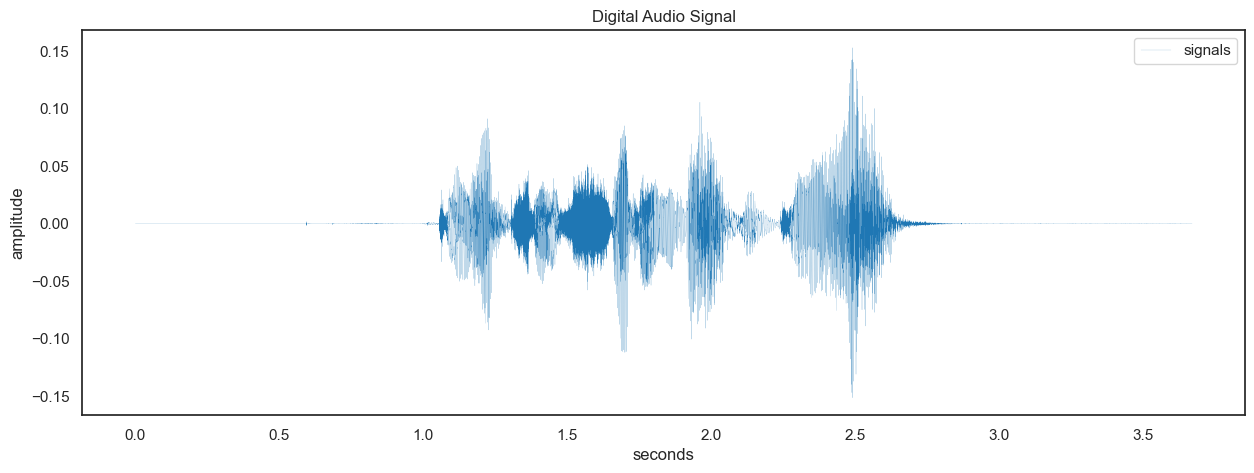

In [74]:
# plotting digital signal
duration = int(math.floor( (len(digital_signal)/sample_rate) + 1))
sound_df = pd.DataFrame({
    "signals": digital_signal,
    "seconds": np.array([i/sample_rate for i in range(0,len(digital_signal))])
})
sound_df.plot(y="signals", x="seconds", figsize=(15,5), lw=0.1, title="Digital Audio Signal", xlabel="seconds", ylabel="amplitude")